In [86]:
import pandas as pd
train_data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
sample = pd.read_csv("../data/sample_submission.csv")

train_data

,Unnamed: 0,fuv_mag,nuv_mag,Vmag,Bmag,err,variable
0,0,22.833,18.196,14.124,14.648,0.125252,1
1,1,21.355,14.965,10.864,11.392,0.031765,0
2,2,19.301,15.520,12.209,12.558,0.056639,0
3,3,22.932,16.382,12.155,12.716,0.090443,0
4,4,20.907,15.071,10.964,11.693,0.068600,0
...,...,...,...,...,...,...,...
47984,47984,22.047,19.313,16.853,17.050,0.162250,0
47985,47985,22.250,16.064,11.039,11.667,0.096213,0
47986,47986,21.798,16.578,12.789,13.319,0.101237,0
47987,47987,24.039,16.784,12.245,12.985,0.153287,0


In [87]:
import torch

train = train_data.iloc[:, 1:6]
labels = train_data["variable"]
print(train.shape, labels.shape)

X = torch.from_numpy(train.values).type(torch.float)
Y = torch.from_numpy(labels.values).type(torch.float)

(47989, 5) (47989,)


In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [89]:
from torch import nn
from torch.optim.lr_scheduler import StepLR

features_n = 60

device = "cuda" if torch.cuda.is_available() else "cpu"

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=5, out_features=features_n)
        self.act1 = nn.ReLU()
        self.layer_2 = nn.Linear(in_features=features_n, out_features=features_n)
        self.act2 = nn.ReLU()
        self.layer_3 = nn.Linear(in_features=features_n, out_features=features_n)
        self.act3 = nn.ReLU()
        self.layer_4 = nn.Linear(in_features=features_n, out_features=1)

        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.act1(self.layer_1(x))
        x = self.act2(self.layer_2(x))
        x = self.act3(self.layer_3(x))
        x = self.sigmoid(self.layer_4(x))
        return x

model = Model().to(device)
# Calculate class weights
num_zeros = torch.sum(Y_train == 0).item()
num_ones = torch.sum(Y_train == 1).item()
weight_for_1 = num_zeros / num_ones # Higher weight for class 1
print(weight_for_1)
pos_weight = torch.tensor([weight_for_1]).to(device)

# Define loss function with pos_weight
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

def recall_fn(y_true, y_pred):
    tp = torch.sum(torch.logical_and(y_true == 1, y_pred == 1)).item()
    recall = (tp / torch.sum(y_true == 1).item()) * 100
    return recall

torch.manual_seed(42)

epochs = 2000
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

for epoch in range(epochs):
    model.train()

    # Forward pass
    y_logits = model(X_train).squeeze()
    # print((y_logits == 0.).sum(dim=0))
    y_pred = torch.round(y_logits)  # Binary predictions (0 or 1)
    # Calculate loss and accuracy
    loss = loss_fn(y_logits, Y_train)  # Pass probabilities to loss function
    acc = accuracy_fn(y_true=Y_train, y_pred=y_pred)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch % 5000 and epoch < 20000):
        scheduler.step()
    
    # Evaluation
    model.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(test_logits)  # Binary predictions (0 or 1)
        # Calculate test loss, accuracy, and recall
        test_loss = loss_fn(test_logits, Y_test)  # Pass probabilities to loss function
        test_acc = accuracy_fn(y_true=Y_test, y_pred=test_pred)
        test_recall = recall_fn(y_true=Y_test, y_pred=test_pred)

    # Print metrics
    if epoch % 500 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%, Test recall: {test_recall:.2f}")

30.62355848434926
Epoch: 0 | Loss: 1.36533, Accuracy: 96.84% | Test loss: 1.34341, Test acc: 96.91%, Test recall: 0.00
Epoch: 500 | Loss: 1.14357, Accuracy: 86.60% | Test loss: 1.14103, Test acc: 86.08%, Test recall: 75.76
Epoch: 1000 | Loss: 1.12964, Accuracy: 89.11% | Test loss: 1.12778, Test acc: 85.32%, Test recall: 78.45
Epoch: 1500 | Loss: 1.12786, Accuracy: 87.72% | Test loss: 1.12499, Test acc: 87.06%, Test recall: 77.10


In [90]:
model(X_train[0])

tensor([1.1983e-06], device='cuda:0', grad_fn=<SigmoidBackward0>)

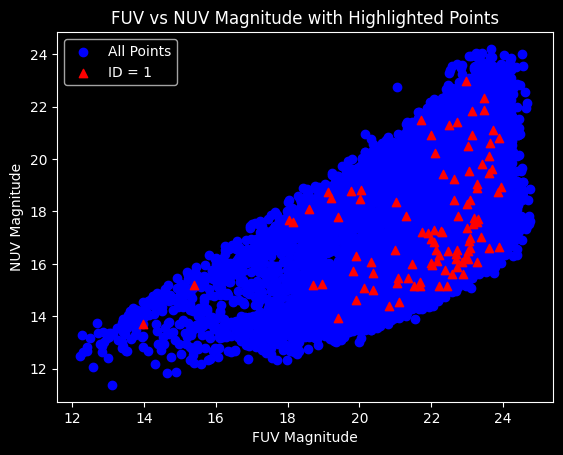

In [91]:
import matplotlib.pyplot as plt
test_fuv = test["fuv_mag"]
test_nuv = test["nuv_mag"]
id = sample["0"]
highlight_fuv = test_fuv[id == 1][:100]
highlight_nuv = test_nuv[id == 1][:100]

# Plot
plt.style.use("dark_background")

# Main scatter plot (all points with dots)
plt.scatter(test_fuv, test_nuv, label="All Points", color="blue")

# Overlay scatter plot for highlighted points (triangles)
plt.scatter(highlight_fuv, highlight_nuv, marker="^", color="red", label="ID = 1")

# Add labels, legend, and title
plt.xlabel("FUV Magnitude")
plt.ylabel("NUV Magnitude")
plt.title("FUV vs NUV Magnitude with Highlighted Points")
plt.legend()